In [1]:
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.stats import laplace,bernoulli,multivariate_normal
import time
import scipy
import sys
#sys.path.insert(1, "../")
sys.path.insert(1,"./../PSIS/py/")
import psis
from scipy.special import logsumexp
import pickle
import os
import stan_utility

In [2]:
data_folder = "../R_codes/Logistic_Model_R/Preprocessed_data"
dataset = 'Voice_preprocessed.csv'
voice = pd.read_csv(os.path.join(data_folder, dataset))

In [3]:
stanmodel = """
data {
  int <lower=0> n;                
  int <lower=0> p;                
  int <lower=0, upper=1> y[n];    
  matrix [n,p] X;             // X does not have the intercept           
  real <lower=0> scale_global;
  int <lower=0,upper=1> mixis;                
}
transformed data {
  real<lower=1> nu_global=1; // degrees of freedom for the half-t priors for tau
  real<lower=1> nu_local=1;  // degrees of freedom for the half-t priors for lambdas
                             // (nu_local = 1 corresponds to the Cauchy)
  real<lower=0> slab_scale=2;// for the regularized horseshoe old was 3
  real<lower=0> slab_df=10;   // for the regularized horseshoe old was 4
}
parameters {
  vector[p] z;                // for non-centered parameterization
  real <lower=0> tau;         // global shrinkage parameter
  vector <lower=0>[p] lambda; // local shrinkage parameter
  real<lower=0> caux;
}
transformed parameters {
  vector[p] beta;
  { 
    vector[p] lambda_tilde;   // 'truncated' local shrinkage parameter
    real c = slab_scale * sqrt(caux); // slab scale: k*IG(a,b) = IG(a,kb)
    lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2*square(lambda)));
    beta =  z .* lambda_tilde*tau;
  }
}
model {
  vector[n] means=X*beta;                                       
  vector[n] log_lik;
  target += std_normal_lpdf(z);
  target += student_t_lpdf(lambda | nu_local, 0, 1);            // nu_local=1 gives a Cauchy prior
  target += student_t_lpdf(tau | nu_global, 0, scale_global);
  target += inv_gamma_lpdf(caux | 0.5*slab_df, 0.5*slab_df);
  for (index in 1:n) {
    log_lik[index]= bernoulli_logit_lpmf(y[index] | means[index]);
  }
  target += sum(log_lik);
  if (mixis) {
    target += log_sum_exp(-log_lik);
  }
}
generated quantities {
  vector[n] means=X*beta;
  vector[n] log_lik;
  for (index in 1:n) {
    log_lik[index] = bernoulli_logit_lpmf(y[index] | means[index]);
  }
}
"""


stanmodel_intercept = """
data {
  int <lower=0> n;                
  int <lower=0> p;                
  int <lower=0, upper=1> y[n];    
  matrix [n,p] X;             // X does not have the intercept           
  real <lower=0> scale_global;
  int <lower=0,upper=1> mixis;                
}
transformed data {
  real<lower=1> nu_global=1; // degrees of freedom for the half-t priors for tau
  real<lower=1> nu_local=1;  // degrees of freedom for the half-t priors for lambdas
                             // (nu_local = 1 corresponds to the Cauchy)
  real<lower=0> slab_scale=2;// for the regularized horseshoe old was 3
  real<lower=0> slab_df=10;   // for the regularized horseshoe old was 4
}
parameters {
  vector[p] z;                // for non-centered parameterization
  real <lower=0> tau;         // global shrinkage parameter
  vector <lower=0>[p] lambda; // local shrinkage parameter
  real<lower=0> caux;
  real alpha;                 // intercept, we put a flat prior
}
transformed parameters {
  vector[p] beta;
  { 
    vector[p] lambda_tilde;   // 'truncated' local shrinkage parameter
    real c = slab_scale * sqrt(caux); // slab scale: k*IG(a,b) = IG(a,kb)
    lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2*square(lambda)));
    beta = z .* lambda_tilde*tau;
  }
}
model {
  vector[n] means=X*beta;                                       // X does not have the intercept
  vector[n] log_lik;          
  target += std_normal_lpdf(z);
  target += student_t_lpdf(lambda | nu_local, 0, 1);            // nu_local=1 gives a Cauchy prior
  target += student_t_lpdf(tau | nu_global, 0, scale_global);
  target += inv_gamma_lpdf(caux | 0.5*slab_df, 0.5*slab_df);
  for (index in 1:n) {
    log_lik[index]= bernoulli_logit_lpmf(y[index] | alpha + means[index]);
  }
  target += sum(log_lik);
  if (mixis) {
    target += log_sum_exp(-log_lik);
  }
}
generated quantities {
  vector[n] means=X*beta;
  vector[n] log_lik;
  for (index in 1:n) {
    log_lik[index] = bernoulli_logit_lpmf(y[index] | alpha + means[index]);
  }
}
"""

In [4]:
y = voice['y']
X = voice.iloc[::, 1:].values
X_intercept = voice.iloc[::, 2:].values
n = X.shape[0]
p = X.shape[1]
p0 = 10
#std_intercept=3

## 2 is the correction due to having a non-gaussian likelihood
scale_global = 2*p0/(p-p0)/np.sqrt(n)
standata_intercept = {'n' : n, 'p' : p-1, 'X':X_intercept, 'y' : y, 'scale_global' : scale_global, 'mixis' : 1}
standata = {'n' : n, 'p' : p, 'X':X, 'y' : y, 'scale_global' : scale_global, 'mixis' : 1}

In [5]:
sm_intercept = pystan.StanModel(model_code=stanmodel_intercept)
sm = pystan.StanModel(model_code=stanmodel)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8e0d5b9acfb842e542879f2aa7fd21e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_befb88feade2236e4532f863c188b913 NOW.


In [6]:
## standata tell him wheter it is a mixture or not
fit_mix = sm.sampling(data=standata, iter=4000, chains=4, warmup=1000, seed=101)

In [7]:
stan_utility.check_all_diagnostics(fit_mix)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 8000 iterations ended with a divergence (0.0%)
0 of 8000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [ ]:
#fit_mix_intercept = sm_intercept.sampling(data=standata_intercept, iter=8000, chains=8, warmup=1000, seed=101)

In [8]:
stan_utility.check_all_diagnostics(fit_mix_intercept)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 8000 iterations ended with a divergence (0.0%)
0 of 8000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


(array([  14.,   99.,  432., 1198., 2029., 2113., 1394.,  563.,  135.,
          23.]),
 array([-3.54509172e+00, -2.83621188e+00, -2.12733204e+00, -1.41845221e+00,
        -7.09572368e-01, -6.92529606e-04,  7.08187309e-01,  1.41706715e+00,
         2.12594699e+00,  2.83482682e+00,  3.54370666e+00]),
 <BarContainer object of 10 artists>)

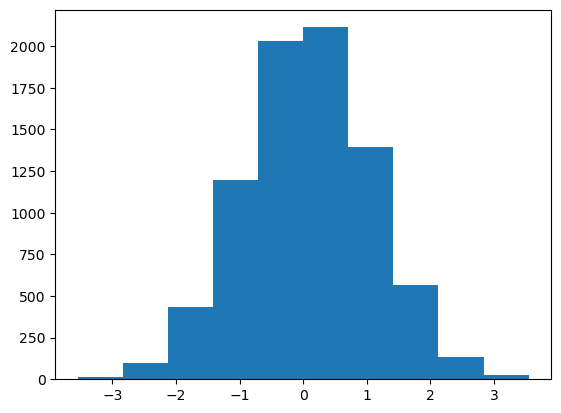

In [23]:
plt.hist(fit_mix['z'][::,4])

(array([ 261., 1555., 2379., 1893., 1089.,  509.,  203.,   81.,   23.,
           7.]),
 array([ 0.86469019,  1.80441837,  2.74414655,  3.68387473,  4.62360291,
         5.56333109,  6.50305927,  7.44278746,  8.38251564,  9.32224382,
        10.261972  ]),
 <BarContainer object of 10 artists>)

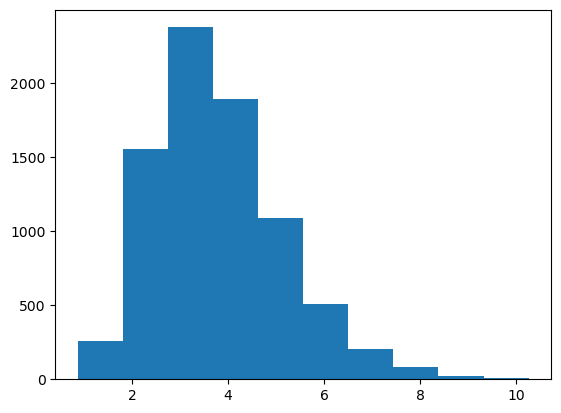

In [16]:
plt.hist(fit_mix_intercept['alpha'])

(array([  14.,   81.,  517., 1437., 2398., 2142., 1090.,  273.,   43.,
           5.]),
 array([-3.76050572, -2.96594922, -2.17139273, -1.37683623, -0.58227974,
         0.21227676,  1.00683325,  1.80138975,  2.59594624,  3.39050274,
         4.18505923]),
 <BarContainer object of 10 artists>)

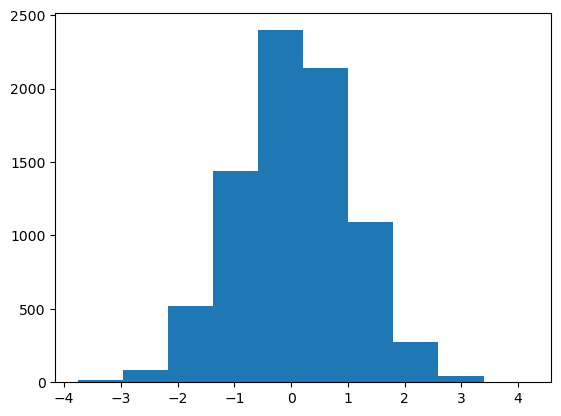

In [24]:
plt.hist(fit_mix_intercept['z'][::,3])

(array([  1.,   2.,   9.,  26.,  85., 113.,  53.,  13.,   7.,   2.]),
 array([-0.08302256, -0.06786483, -0.0527071 , -0.03754936, -0.02239163,
        -0.0072339 ,  0.00792383,  0.02308157,  0.0382393 ,  0.05339703,
         0.06855476]),
 <BarContainer object of 10 artists>)

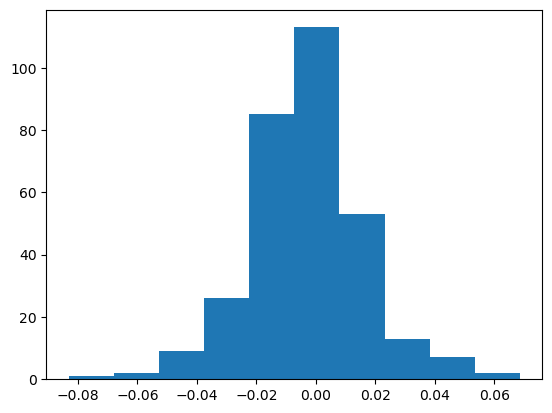

In [28]:
plt.hist(np.mean(fit_mix['z'][::, 1:], axis=0) - np.mean(fit_mix_intercept['z'][::, 0:], axis=0))

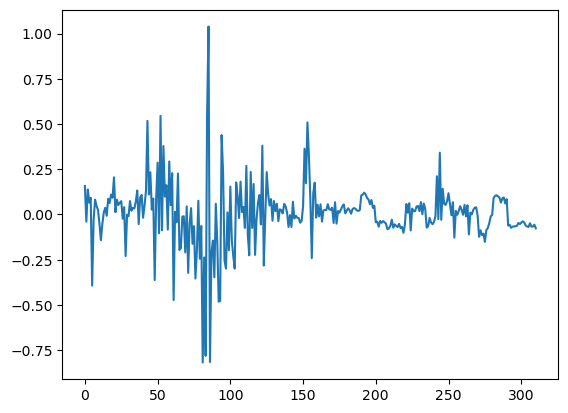

In [27]:
plt.plot(np.mean(fit_mix_intercept['z'][::, 0:], axis=0))

In [12]:
log_lik_mix = fit_mix_intercept['log_lik']
n_samples = log_lik_mix.shape[0]
l_common_mix = logsumexp(-log_lik_mix, axis=1)
log_weights = -log_lik_mix - l_common_mix.reshape((n_samples,1))
elpd_mixis = logsumexp(-l_common_mix) - logsumexp(np.transpose(log_weights), axis=1)


In [13]:
np.sum(elpd_mixis)

-44.61443438647288